In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import  RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.model_selection import train_test_split, GridSearchCV
import itertools
import pandas as pd
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_val_predict
import seaborn as sns
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

 **“Proyecto 2 – Modelos de clasificación supervisada para evaluar la calidad de un automovil”**
 - Carlos Andres Zambrano Betancourt
 - Omar Leonardo Susa Puentes

**Planteamiento del problema**

La Base de Datos de Evaluación de Automóviles se derivó de un modelo de decisión jerárquico simple desarrollado originalmente para la demostración de DEX, M. Bohanec, V. Rajkovic: Sistema experto para la toma de decisiones. Sistemica 1(1), pp. 145-157, 1990.). El modelo evalúa los automóviles según la siguiente estructura conceptual:

- CAR aceptabilidad del automóvil
  - unacc inaceptable
  - acc aceptable
  - good bueno
  - vgood muy bueno
- PRICE precio general
  - buying precio de compra
  - maint precio del mantenimiento
- TECH características técnicas
   - doors número de puertas
   - persons capacidad en términos de personas a transportar
   - lug_boot tamaño del maletero
   - safety seguridad estimada del automóvil

Los atributos de entrada están escritos en minúsculas. Además del concepto objetivo (CAR), el modelo incluye tres conceptos intermedios: PRICE, TECH, COMFORT. Cada concepto está relacionado en el modelo original con sus descendientes de nivel inferior mediante un conjunto de ejemplos (para estos conjuntos de ejemplos, consulte http://www-ai.ijs.si/BlazZupan/car.html).

La Base de Datos de Evaluación de Automóviles contiene ejemplos con la información estructural eliminada, es decir, relaciona directamente CAR con los seis atributos de entrada: buying, maint, doors, persons, lug_boot, safety.

Debido a la conocida estructura subyacente del concepto, esta base de datos puede ser particularmente útil para probar métodos de inducción constructiva y descubrimiento de estructuras.

# **EDA**

## **Carga de datos**

Se procede a realizar la carga de datos.

In [8]:
df = pd.read_csv("https://raw.githubusercontent.com/leonardosusa7/EAN_MachineLearning_I/main/car.data", names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'Class'])
df.head()

,buying,maint,doors,persons,lug_boot,safety,Class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


En este punto categorizamos los campos de la base de datos segun su valor, en sí todos son datos categoricos.

In [37]:
ordenes = {'buying' : ['low','med','high','v-high'], 
            'maint' : ['low','med','high','v-high'],
            'doors' : ['2', '3', '4', '5-more'],
            'persons' : ['2', '4', 'more'],
            'lug_boot' : ['small', 'med', 'big'],
            'safety' : ['low', 'med', 'high'],
            'Class' : ['unacc', 'acc', 'good', 'vgood']}

for i in ordenes.keys():
    if i == 'Class':
        df[i] = pd.Categorical(df[i], categories=ordenes[i])
    else:
        df[i] = pd.Categorical(df[i], categories=ordenes[i], ordered=True)

Calculamos la dimensionalidad de los datos donde tenemos 1728 registros y 7 columnas

In [38]:
df.shape

(1728, 7)

Utilizamos la función .info() para revisar el tipo de datos por cada columna y si tienen la misma cantidad de datos, el cual, podemos observar que hay una diferencia en buying, maint y doors referente a las otras columnas.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   buying    1296 non-null   category
 1   maint     1296 non-null   category
 2   doors     1296 non-null   category
 3   persons   1728 non-null   category
 4   lug_boot  1728 non-null   category
 5   safety    1728 non-null   category
 6   Class     1728 non-null   category
dtypes: category(7)
memory usage: 13.1 KB


Como podemos observar con la combinación de los metodos isna() y Sum() determinamos el numero de datos vacios

In [6]:
df.isna().sum()

buying      432
maint       432
doors       432
persons       0
lug_boot      0
safety        0
Class         0
dtype: int64

Resulta que al revisar la fuente de los datos, se encuentra que esos valores correspondian a las etiquetas 'V-high' de la columna buying, 'V-high' de la columna maint y '5-more' de la columna doors; esta decision de asignación de datos nulos se da porque en el mismo documento de soporte indica que todos los campos y etiquetas de cada uno de ellos tenian que estar, que no habian datos nulos.

In [7]:
df['buying'] = df['buying'].fillna('v-high')
df['maint'] = df['maint'].fillna('v-high')
df['doors'] = df['doors'].fillna('5-more')

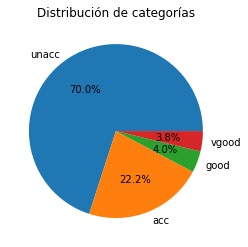

In [8]:
proporcion_categorias = df['Class'].value_counts(normalize=True)
proporcion_categorias.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribución de categorías')
plt.ylabel('')
plt.show()

Como se puede apreciar en la distribución de las clases, hay un desbalanceo notable de las clases, donde la mayor predominancia se encuentra en 'inaceptables' con un 70% de participación, seguido de 'aceptables' con un 22.2% y por ultimo 'bueno' y 'muy bueno' con un 4% y 3.8% respectivamente.

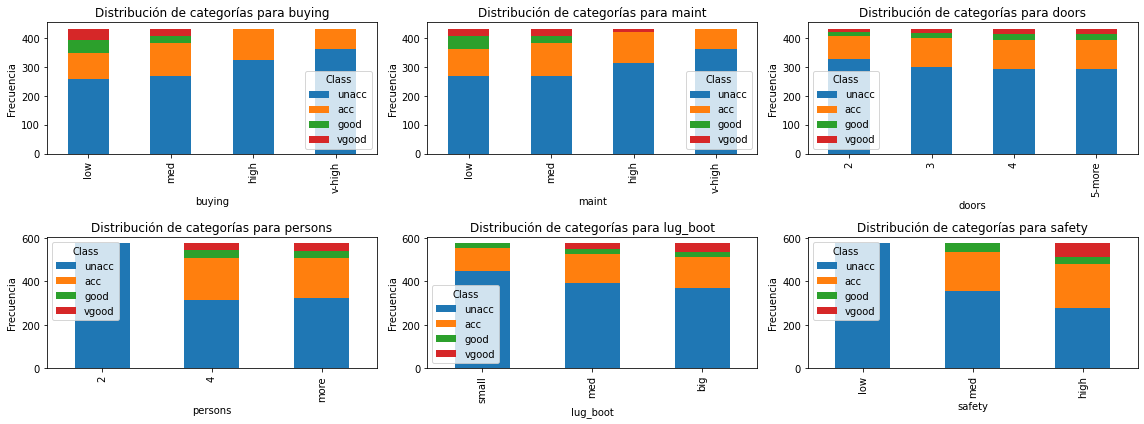

In [9]:
ordenes = {'buying' : ['low','med','high','v-high'], 
            'maint' : ['low','med','high','v-high'],
            'doors' : ['2', '3', '4', '5-more'],
            'persons' : ['2', '4', 'more'],
            'lug_boot' : ['small', 'med', 'big'],
            'safety' : ['low', 'med', 'high'],}

plt.figure(figsize=(16, 6))

# Itera sobre las claves del diccionario 'ordenes'
for i, grupo in enumerate(ordenes.keys(), start=1):
    plt.subplot(2, 3, i)  # Crea un subplot en la posición i del grid 2x3
    tabla_contingencia = pd.crosstab(df[grupo],df['Class'])
    tabla_contingencia.plot(kind='bar', stacked=True, ax=plt.gca())  # Utiliza el eje actual
    plt.title(f'Distribución de categorías para {grupo}')
    plt.xlabel(grupo)
    plt.ylabel('Frecuencia')
    plt.legend(title='Class')
    plt.tight_layout()  # Ajusta automáticamente los subplots para evitar solapamientos

plt.show()  # Muestra l

Como podemos apreciar en el subplot de arriba, las variables predictorias guardan una relación muy proporcional a la distribucíon de las categorias de la variable dependiente "Class", donde los punto revelante son los siguientes:

- En las variables buying y maint encontramos  que la relación con la variable class sus categorias 'v-high' y 'high' se encuentran a un alto costo es decir 'v-high' y 'high' respectivamente.
- En la variable doors se encuentran en las 3 categorias de la variable class, donde hay una proporción equi-distribuida aproximadamente.
- La variable person, encontramos, que la categoria 'inaceptable' predomina con la categoria '2 personas' de capacidad, las demas categorias de doors estan equi-distribuida con las categorias de Class.
- La variable lug_boot tiene como particularidad que al ser pequeño "small" no contenga la categoria 'muy bueno', y que en las demas clasificaciones de lug_boot tengan una proporcion similar a la de la variable Class.
- La variable safety tenemos un comportamiento en la distribución de las categorias Class en la variable safaty, sin embargo como punto diferenciados cuando la seguridad es media no contamos con categoria 'muy bueno' de la variable class.

Por uttimo podemos apreciar que todas las variables independientes estan equidistribuidas haciendo de que sea mucho mas facil la dinamica de asignación y de los modelos a seleccionar.

El paso siguiente es transformar variables independientes que tienen tipo de valor categorico a variables dummy de tipo dicotomico con valores entre 0 y 1

In [10]:
df_dummies = pd.get_dummies(df[['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety']], dtype= int)
df = pd.concat([df['Class'], df_dummies], axis=1)

Dividimos el dataframe ya manipulado en los insumos que requiere los modelos matematios; en variable dependiente (y) e independientes (X).

In [11]:
X = df[['buying_low', 'buying_med', 'buying_high', 'buying_v-high',
       'maint_low', 'maint_med', 'maint_high', 'maint_v-high', 'doors_2',
       'doors_3', 'doors_4', 'doors_5-more', 'persons_2', 'persons_4',
       'persons_more', 'lug_boot_small', 'lug_boot_med', 'lug_boot_big',
       'safety_low', 'safety_med', 'safety_high']]
y = df['Class']

## **Aplicación de los modelos**

### Modelos con parametros predeterminados:

Creamos una función que recibira los parametros 'X' y 'y' definidos anteriormente, en el, utilizamos los modelos de random forest, decision tree, support vector machine, Naivie Bayes y gradient boosting, adicional a ello, se definio 3 modelos que tienen en sus argumentos la posibilidad de regularizar o penalizar las clases desbalanceadas; es importante tener en cuenta, que este ejercicio como se hablo anteriormente, sus clases estan desbalanceadas y por tal motivo se aplicaran estrategias de oversampling, undersamplig, smote y sus variante y la misma data sin balancear, ya que solo aplicara para los modelos regularizados o penalizados, por utlmio, retornara 2 salidas que contendran las metricas de clasificación ponderadas, dado a que estamos en un problema de clasificación multiclase y sus parametros de curva ROC - AUC en dado caso que las metricas generales nos presente dudas respecto al mejor modelos que describe esta clasificación.

In [12]:
def balance_and_train(X, y):
    # Dividir los datos en conjunto de entrenamiento y prueba
    np.random.seed(42)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Definir modelos
    models = {
        'Random Forest': RandomForestClassifier(),
        'Random Forest - balanceo': RandomForestClassifier(class_weight={'unacc': 1, 'acc': 3, 'good': 10, 'vgood': 40}),
        'Decision Tree': DecisionTreeClassifier(),  
        'Decision Tree - balanceo' : DecisionTreeClassifier(class_weight='balanced'),  # Penalización por desbalanceo
        'SVM' : SVC(probability= True),
        'SVM - balanceo': SVC(class_weight='balanced', probability= True),  # Penalización por desbalanceo
        'Naive Bayes' : GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    # Definir técnicas de balanceo
    samplers = {
        'Random UnderSampler': RandomUnderSampler(),
        'Random OverSampler': RandomOverSampler(),
        'SMOTE': SMOTE(),
        'SMOTE TOMEK' : SMOTETomek(),
        'SMOTEENN': SMOTEENN(),
        'Normal': 'Normal'
    }
    
    # Diccionario para almacenar las métricas de rendimiento y las curvas ROC-AUC
    performance_metrics = {}
    roc_auc_parametros = {}
    table_cross_validation = {}
    
    # Iterar sobre técnicas de balanceo y modelos
    for sampler_name, sampler in samplers.items():
        for model_name, model in models.items():
            if sampler_name == 'Normal' and '- balanceo' in model_name:
                #print(f"Balanceo: {sampler_name}, Modelo: {model_name}")
                pipeline = Pipeline([('model', model)])
            elif sampler_name != 'Normal' and '- balanceo' not in model_name:
                #print(f"Balanceo: {sampler_name}, Modelo: {model_name}")
                pipeline = Pipeline([
                    ('sampler', sampler),
                    ('model', model)
                ])
            else:
                continue
            
            # Entrenar el modelo
            pipeline.fit(X_train, y_train)
            
            # Evaluar el modelo en el conjunto de prueba
            y_pred = pipeline.predict(X_test)
            #report = classification_report(y_test, y_pred, output_dict=True)
            Accuracy = accuracy_score(y_test, y_pred)
            Precision =  precision_score(y_test, y_pred, average='weighted')  # Promedio ponderado
            Recall = recall_score(y_test, y_pred, average='weighted')  # Promedio ponderado
            F1_score = f1_score(y_test, y_pred, average='weighted')  # Promedio ponderado
            performance_metrics[(sampler_name, model_name)] = {'Accuracy':Accuracy,'Precision': Precision,'Recall': Recall,'F1': F1_score}
            
            # Obtener datos para generar ROC-AUC
            y_pred_prob = pipeline.predict_proba(X_test)
            clases = pipeline.classes_
            for i in range(len(clases)):
                model_fpr, model_tpr, _ = roc_curve(label_binarize(y_test, classes=pipeline.classes_)[:, i], y_pred_prob[:, i])
                auc_model = auc(model_fpr, model_tpr)
                roc_auc_parametros[(sampler_name, model_name, clases[i])] = {'x': model_fpr, 'y': model_tpr, 'AUC': auc_model}
    return performance_metrics, roc_auc_parametros

# Aplicación inicial
performance_metrics, roc_auc_parametros = balance_and_train(X, y)  # Reemplaza X e y con tus datos de entrada

Una vez aplicado los modelos con sus parametros predeterminados, procedemos a procesarlos y dejarlos listos en un dataframe para visualizar las metricas y en función a ello y tener una primera impresión del ejercicio.

In [13]:
df_metricas_ini = pd.DataFrame(performance_metrics).T.reset_index()
df_metricas_ini = df_metricas_ini.rename(columns={'level_0': 'Tecnica_Balanceo','level_1':'Modelo'})
df_metricas_ini = df_metricas_ini.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)  
df_metricas_ini

,Tecnica_Balanceo,Modelo,Accuracy,Precision,Recall,F1
0,Random OverSampler,SVM,0.985549,0.986430,0.985549,0.985701
1,SMOTE,Gradient Boosting,0.976879,0.978134,0.976879,0.977166
2,Normal,Random Forest - balanceo,0.976879,0.977427,0.976879,0.976843
3,SMOTE,SVM,0.976879,0.978134,0.976879,0.977166
4,Random OverSampler,Gradient Boosting,0.973988,0.975621,0.973988,0.974352
5,SMOTE TOMEK,Random Forest,0.971098,0.972705,0.971098,0.971420
6,Random OverSampler,Random Forest,0.971098,0.972673,0.971098,0.971433
7,SMOTE TOMEK,SVM,0.971098,0.972962,0.971098,0.971542
8,SMOTE TOMEK,Gradient Boosting,0.968208,0.970775,0.968208,0.968756
9,Random OverSampler,Decision Tree,0.959538,0.959656,0.959538,0.959344


Basándonos en los datos proporcionados para un problema de clasificación multiclase y considerando las métricas de evaluación (accuracy, precision, recall y F1-score) para diferentes técnicas de balanceo y modelos, podemos hacer varias inferencias:

- **Alto rendimiento general:** En general, todos los modelos parecen tener un rendimiento bastante alto, con valores de accuracy, precision, recall y F1-score cercanos a 1. Esto sugiere que los modelos son capaces de clasificar correctamente la mayoría de las clases en el conjunto de datos.

- **Consistencia en el rendimiento:** Los valores de las métricas de evaluación son bastante consistentes entre las diferentes técnicas de balanceo y modelos. Por ejemplo, los modelos utilizando Random OverSampler y SMOTE tienen valores de precisión, recall y F1-score bastante similares, independientemente del modelo específico utilizado (SVM o Gradient Boosting).

- **Random OverSampler y SMOTE:** Estas técnicas de balanceo parecen ser efectivas para mejorar el rendimiento de los modelos, ya que los modelos entrenados con datos generados por estas técnicas tienden a tener un rendimiento ligeramente mejor o comparable en comparación con el modelo entrenado con datos sin balanceo (normal).

- **Elección del modelo:** Parece que SVM y Gradient Boosting son modelos efectivos para este problema de clasificación multiclase, ya que muestran un rendimiento similar en términos de accuracy, precision, recall y F1-score.

En resumen, los datos sugieren que las técnicas de balanceo como Random OverSampler y SMOTE pueden ser útiles para mejorar el rendimiento de los modelos en problemas de clasificación multiclase, y tanto SVM como Gradient Boosting son modelos prometedores para este tipo de problema. Sin embargo, se hara una segunda validación con mejoramiento de parametros con el metodo gridsearch el cual le pasaremos unos hiperparametros para encontrar la mejor combinación de estos metodos y modelos propuestos.

### Modelos con hiperparametros:

Creamos otra función que recibira los parametros 'X' y 'y' definidos anteriormente, en el, utilizamos el metodo 'GridSearchCV', y estimamos los hiperparametros para cada modelos, en este caso el modelo de Naive Bayes no tiene parámetros ajustables (también conocidos como hiperparámetros), no hay nada que optimizar o ajustar durante el entrenamiento del modelo. La suposición ingenua de independencia condicional elimina la necesidad de ajustar parámetros, ya que el modelo simplemente calcula probabilidades basadas en frecuencias observadas en los datos de entrenamiento.

A continuación en listo los modelos y los parametros que afectaremos:

**Random Forest:**

- *n_estimators:* Es el número de árboles en el bosque. Cuantos más árboles se agreguen, más robusto será el modelo contra el sobreajuste, pero también aumentará el costo computacional.

**Decision Tree:**

- *max_depth:* Es la profundidad máxima del árbol de decisión. Controla la complejidad del modelo al limitar la cantidad de divisiones que puede realizar el árbol. Un árbol más profundo puede aprender relaciones más complejas en los datos, pero también puede sobreajustar si no se controla adecuadamente.

**SVM (Support Vector Machine):**

- *C:* Es el parámetro de regularización, que controla el equilibrio entre el error de clasificación y la maximización del margen. Un valor más alto de C permite clasificaciones más complejas que pueden sobreajustar los datos de entrenamiento.

- *gamma:* Es un parámetro del kernel que controla la influencia de un solo ejemplo de entrenamiento. Los valores más altos de gamma conducen a una mayor precisión de entrenamiento, pero también pueden provocar sobreajuste y reducir la capacidad de generalización del modelo.

**Gradient Boosting:**

- *learning_rate:* Es el factor de escala para reducir la contribución de cada árbol. Un valor más bajo de learning_rate requerirá más árboles en el conjunto, pero puede mejorar la capacidad de generalización del modelo y reducir el sobreajuste.

In [18]:
def enhance_model(X, y):
    np.random.seed(42)
    # Dividir los datos en conjunto de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    # Definir modelos
    models = {
        'Random Forest': RandomForestClassifier(),
        'Random Forest - balanceo': RandomForestClassifier(class_weight={'unacc': 1, 'acc': 3, 'good': 10, 'vgood': 40}),
        'Decision Tree': DecisionTreeClassifier(),  
        'Decision Tree - balanceo' : DecisionTreeClassifier(class_weight='balanced'),  # Penalización por desbalanceo
        'SVM' : SVC(probability= True),
        'SVM - balanceo': SVC(class_weight='balanced', probability= True),  # Penalización por desbalanceo
        'Naive Bayes' : GaussianNB(),
        'Gradient Boosting': GradientBoostingClassifier()
    }
    
    # Definir técnicas de balanceo
    samplers = {
        'Random UnderSampler': RandomUnderSampler(),
        'Random OverSampler': RandomOverSampler(),
        'SMOTE': SMOTE(),
        'SMOTE TOMEK' : SMOTETomek(),
        'SMOTEENN': SMOTEENN(),
        'Normal': 'Normal'
    }
    
    # Diccionario para almacenar las métricas de rendimiento y los mejores estimadores
    performance_metrics = {}
    best_estimators = {}
    enhance_model_metrics = {}
    
    for sampler_name, sampler in samplers.items():
        for model_name, model in models.items():
            if sampler_name == 'Normal' and '- balanceo' in model_name:
                #print(f"Balanceo: {sampler_name}, Modelo: {model_name}")
                pipeline = Pipeline([('model', model)])
            elif sampler_name != 'Normal' and '- balanceo' not in model_name:
                #print(f"Balanceo: {sampler_name}, Modelo: {model_name}")
                pipeline = Pipeline([
                    ('sampler', sampler),
                    ('model', model)
                ])
            else:
                continue
                
            # Definir los hiperparámetros a ajustar para cada modelo
            param_grid = {}  # Define los hiperparámetros para el modelo
            if model_name in [ 'Random Forest' , 'Random Forest - balanceo']:
                param_grid = {'model__n_estimators': [50, 100, 200]}
            elif model_name in ['Decision Tree', 'Decision Tree - balanceo']:
                param_grid = {'model__max_depth': [None, 10, 20]}
            elif model_name in ['SVM', 'SVM - balanceo']:
                param_grid = {'model__C': [0.1, 1, 10], 'model__gamma': ['scale', 'auto']}
            elif model_name == 'Gradient Boosting':
                param_grid = {'model__learning_rate': [0.1, 0.01]}
            # Puedes continuar con otros modelos y sus respectivos hiperparámetros
                
            # Configurar GridSearchCV para el modelo actual
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1_macro')
            
            # Entrenar GridSearchCV
            grid_search.fit(X_train, y_train)
            
            # Obtener el mejor estimador
            best_estimator = grid_search.best_estimator_
            
            # Hacer predicciones en el conjunto de prueba
            y_pred = best_estimator.predict(X_test)
            
            # Calcular las métricas de desempeño con validación cruzada
            cv_scores = cross_val_score(best_estimator, X_train, y_train, cv=5, scoring='f1_macro')
            mean_cv_accuracy = cv_scores.mean()
                        
            # Calcular las métricas de desempeño
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')
            accuracy = accuracy_score(y_test, y_pred)        
               
            # Almacenar el mejor estimador y sus métricas de rendimiento
            best_estimators[(sampler_name, model_name)] = best_estimator
            performance_metrics[(sampler_name, model_name)] = grid_search.cv_results_
            enhance_model_metrics[(sampler_name, model_name)] = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1": f1, "Mean CV Accuracy": mean_cv_accuracy}
    
    return performance_metrics, best_estimators, enhance_model_metrics

performance_metrics, best_estimators,  enhance_model_metrics= enhance_model(X, y)

Una vez definida la función con sus respectivos hiperparametros, procedemos a procesarlos y dejarlos listos en un dataframe para visualizar las metricas y en función a ello y validamos respecto a las metricas anteriores.

In [19]:
df_metricas_fin = pd.DataFrame(enhance_model_metrics).T.reset_index()
df_metricas_fin = df_metricas_fin.rename(columns={'level_0': 'Tecnica_Balanceo','level_1':'Modelo'})
df_metricas_fin = df_metricas_fin.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)  
df_metricas_fin

,Tecnica_Balanceo,Modelo,Accuracy,Precision,Recall,F1,Mean CV Accuracy
0,Normal,SVM - balanceo,1.000000,1.000000,1.000000,1.000000,0.991367
1,Random OverSampler,SVM,1.000000,1.000000,1.000000,1.000000,0.993671
2,SMOTE TOMEK,SVM,0.982659,0.983351,0.982659,0.982825,0.906830
3,Normal,Random Forest - balanceo,0.979769,0.980263,0.979769,0.979868,0.882369
4,SMOTE,SVM,0.979769,0.980280,0.979769,0.979892,0.929937
5,SMOTE TOMEK,Gradient Boosting,0.976879,0.978548,0.976879,0.977217,0.911669
6,Random OverSampler,Gradient Boosting,0.973988,0.975621,0.973988,0.974352,0.931084
7,Random OverSampler,Random Forest,0.973988,0.974566,0.973988,0.974174,0.907134
8,SMOTE,Gradient Boosting,0.971098,0.973169,0.971098,0.971549,0.902798
9,SMOTEENN,Gradient Boosting,0.968208,0.970775,0.968208,0.968756,0.868582


Con base en las métricas con los hiperparámetros ajustados, podemos hacer las siguientes observaciones:

- **Alto rendimiento en SVM con técnicas de balanceo:** En general, los modelos SVM (Support Vector Machine) muestran un rendimiento muy alto en todas las técnicas de balanceo, con valores de accuracy, precision, recall y F1-score cercanos a 1. Esto sugiere que SVM es altamente efectivo para este conjunto de datos, incluso después de ajustar los hiperparámetros.

- **Gradient Boosting muestra un rendimiento consistente:** Los modelos Gradient Boosting también tienen un rendimiento sólido en todas las técnicas de balanceo. Aunque no alcanzan la perfección como SVM, muestran valores altos y consistentes en todas las métricas.

- **Rendimiento variable en Random Forest:** Los modelos Random Forest muestran un rendimiento variable dependiendo de la técnica de balanceo utilizada. Algunas técnicas, como Random OverSampler, pueden mejorar el rendimiento de Random Forest, mientras que otras, como Random UnderSampler, pueden tener un impacto negativo.

- **Naive Bayes muestra rendimiento constante pero más bajo:** En contraste con los modelos anteriores, el clasificador Naive Bayes muestra un rendimiento constante pero relativamente más bajo en todas las técnicas de balanceo. Esto sugiere que, si bien Naive Bayes puede ser un modelo simple y rápido, puede no ser tan efectivo para este conjunto de datos en particular en comparación con SVM y Gradient Boosting.

En general, los modelos SVM y Gradient Boosting parecen ser las opciones más prometedoras para este conjunto de datos, especialmente cuando se utilizan técnicas de balanceo para abordar el desequilibrio de clases. Sin embargo, la selección del modelo óptimo puede depender de consideraciones adicionales, como el overfitting de los modelos que tienen en todas sus metricas el valor de 1, por tal motivo es indispenasable realizar un analisis de validación cruzada y la curva ROC - AUC para cada una de las clases segun el modelo y estrategia de balanceo aplicado.

<function matplotlib.pyplot.show(close=None, block=None)>

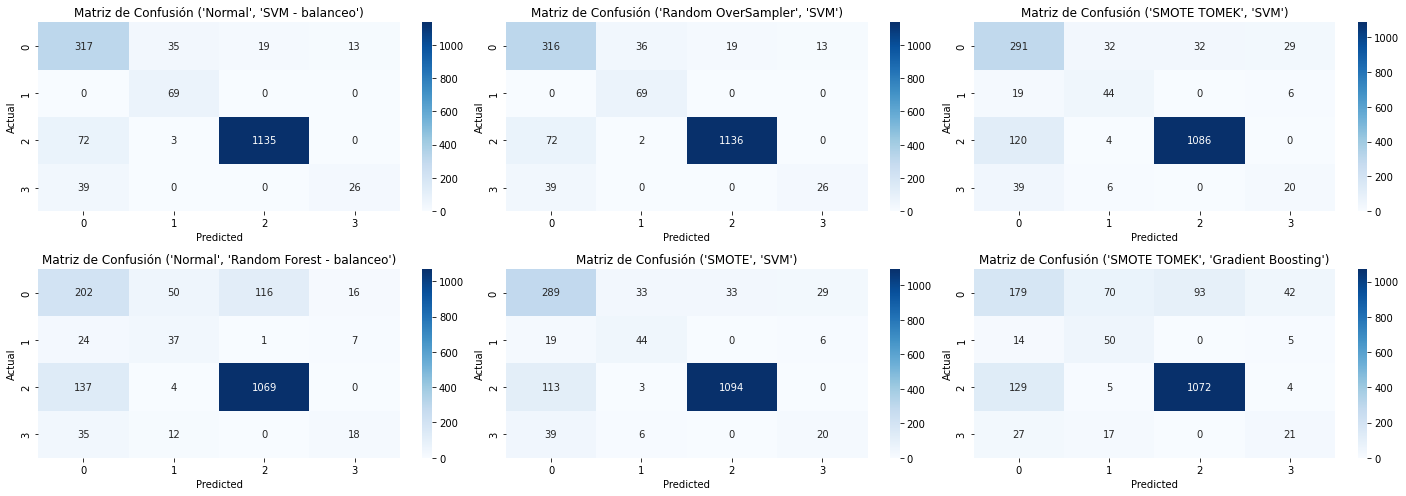

In [20]:
top_6 = []

for indice in range(6):
    top_6.append((df_metricas_fin['Tecnica_Balanceo'][indice], df_metricas_fin['Modelo'][indice]))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20, 7))
for i, grupo in enumerate(top_6, start=1):
    
    plt.subplot(2, 3, i)
    
    # Definir el pipeline
    pipeline = best_estimators[grupo]

    # Ajustar el pipeline al conjunto de entrenamiento
    pipeline.fit(X_train, y_train)
    np.random.seed(42)
    # Obtener las predicciones del modelo utilizando validación cruzada
    y_pred = cross_val_predict(pipeline, X, y, cv=5)  # cv=5 indica 5-fold cross-validation
    
    # Calcular la matriz de confusión
    conf_matrix = confusion_matrix(y, y_pred)

    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")

    plt.title(f"Matriz de Confusión {grupo}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
plt.show


Basandonos en las matrices de confusión para los 6 mejores accuracy de las combinaciones entre técnicas de balanceo y modelos, aquí hay algunas inferencias posibles:

- **SVM con Random OverSampler y Normal:**

Ambas combinaciones muestran resultados muy similares en la matriz de confusión, con altos números de instancias clasificadas correctamente en todas las clases. Esto sugiere que SVM es robusto y efectivo en la clasificación de este conjunto de datos, independientemente de la técnica de balanceo utilizada.

- **Gradient Boosting con Random OverSampler y SMOTE:**

Ambas combinaciones muestran un rendimiento sólido en la clasificación de la mayoría de las clases, pero también muestran cierta dificultad en la clasificación de la clase 1 (segunda fila). Esto puede indicar que Gradient Boosting tiene dificultades para distinguir la clase 1 de otras clases en este conjunto de datos.

- **Comparación entre SVM y Gradient Boosting:**

SVM parece tener un rendimiento ligeramente mejor que Gradient Boosting en términos de la cantidad de instancias clasificadas correctamente en todas las clases. Sin embargo, ambas técnicas muestran un rendimiento sólido y podrían ser buenas opciones para este conjunto de datos.

En resumen, si los datos iniciales muestran métricas perfectas, como accuracy, precision, recall y F1-score de 1, pero la validación cruzada muestra clasificaciones erróneas, hay una clara discrepancia que necesita ser abordada. Es poco probable que un modelo tenga un rendimiento perfecto en los datos de entrenamiento y al mismo tiempo clasifique incorrectamente durante la validación cruzada, creando discrepancias en los resultados. La discrepancia podría deberse a problemas en los datos, como un desequilibrio de clases no manejado correctamente, datos incorrectos o ruido, errores en la implementación del modelo o del proceso de validación cruzada, o la presencia de overfitting en los datos de entrenamiento.

Por tal motivo se procede a graficar las curvas ROC y AUC de cada modelo y técnica de balanceo para determinar cual seria el mejor modelo teniendo en cuenta que los 2 primeros que tienen metricas perfectas pueden tener dificultades en su clasificación.

<function matplotlib.pyplot.show(close=None, block=None)>

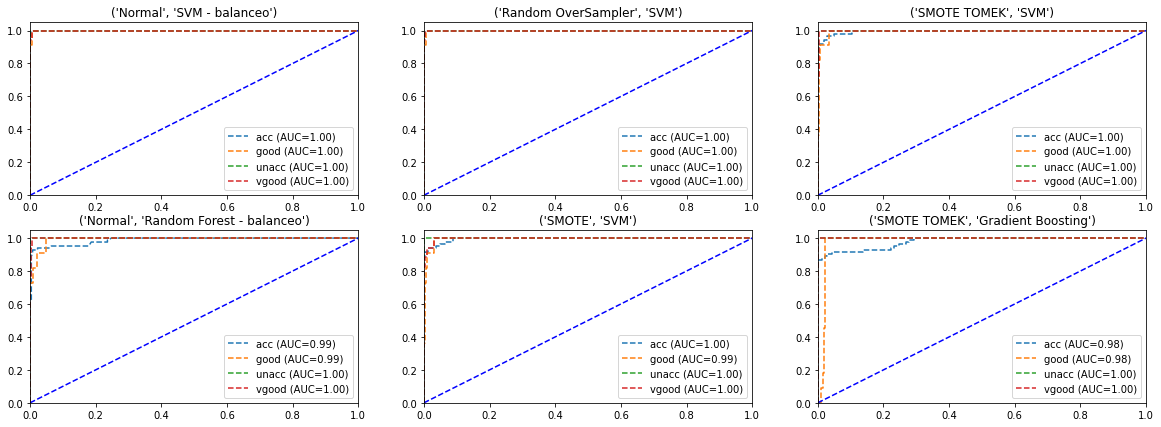

In [21]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
plt.figure(figsize=(20, 7))
for i, grupo in enumerate(top_6, start=1):
    plt.subplot(2, 3, i)
    # Definir el pipeline
    pipeline = best_estimators[grupo]
    # Ajustar el pipeline al conjunto de entrenamiento
    pipeline.fit(X_train, y_train)
    # Obtener las predicciones del modelo utilizando validación cruzada

    # Obtener datos para generar ROC-AUC
    y_pred_prob = pipeline.predict_proba(X_test)
    clases = pipeline.classes_
    for j in range(len(clases)):
        model_fpr, model_tpr, _ = roc_curve(label_binarize(y_test, classes=pipeline.classes_)[:, j], y_pred_prob[:, j])
        auc_model = auc(model_fpr, model_tpr)
        plt.plot(model_fpr,model_tpr, linestyle= '--', label = '%s (AUC=%0.2f)'%(clases[j], auc_model))
    plt.plot([0,1],[0,1], 'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.title(grupo)
    plt.legend(loc='lower right')
plt.show

## Conclusión

Como podemos apreciar en el grafico superior, encontramos que la mejor combinación entre tecnica y medelo de clasificación es SMOTE TOMEK con maquinas de soporte vectorial debido a lo antes mencionado de los problemas que muestran dificultad en sus predicciones de los modelos Random Oversampler - SVM y Datos sin balancear _ SVM penalizado, ya que sus AUC de sus clases tiene el mismo valor de los modelos antes mencionados, adicional a ello es el tecer mejor modelo entre sus metricas ya que sus valores en promedio entre ellas estan en un 0.98, conllevando asi una relación entre la validacion cruzada y la Curva ROC - AUC